Negative Emotion

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15752 entries, 0 to 15751
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Differential1    15752 non-null  int64 
 1   Differential2    15752 non-null  int64 
 2   Differential3    15752 non-null  int64 
 3   Emotion          15752 non-null  object
 4   Local_Timestamp  15752 non-null  object
dtypes: int64(3), object(2)
memory usage: 615.4+ KB
None
       Differential1  Differential2  Differential3
count   15752.000000   15752.000000   15752.000000
mean     2448.526219    2015.957402    2176.644997
std       198.978092     184.181155     203.342067
min      1898.000000    1535.000000    1739.000000
25%      2262.000000    1842.000000    2001.000000
50%      2469.000000    2032.000000    2152.000000
75%      2575.000000    2145.000000    2337.000000
max      2965.000000    2579.000000    2762.000000


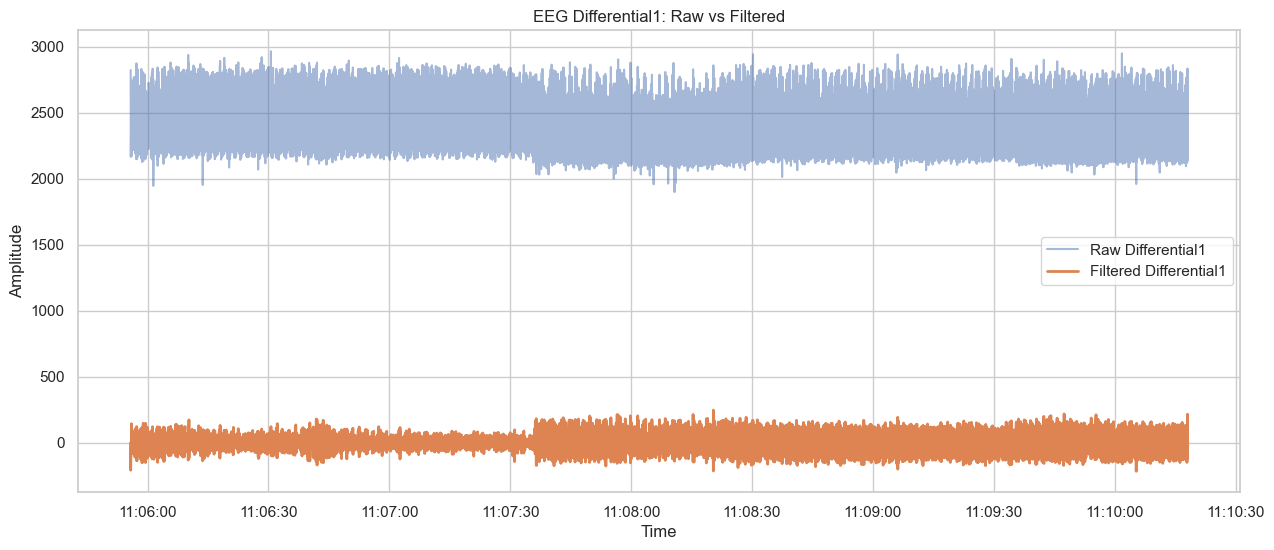

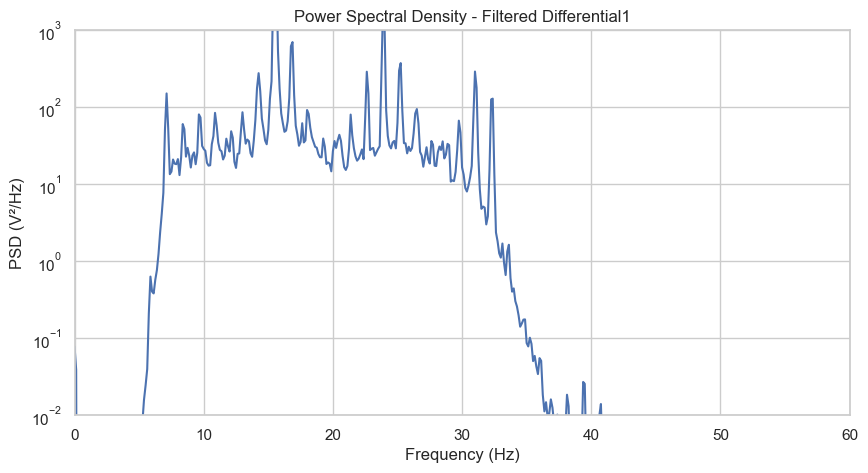

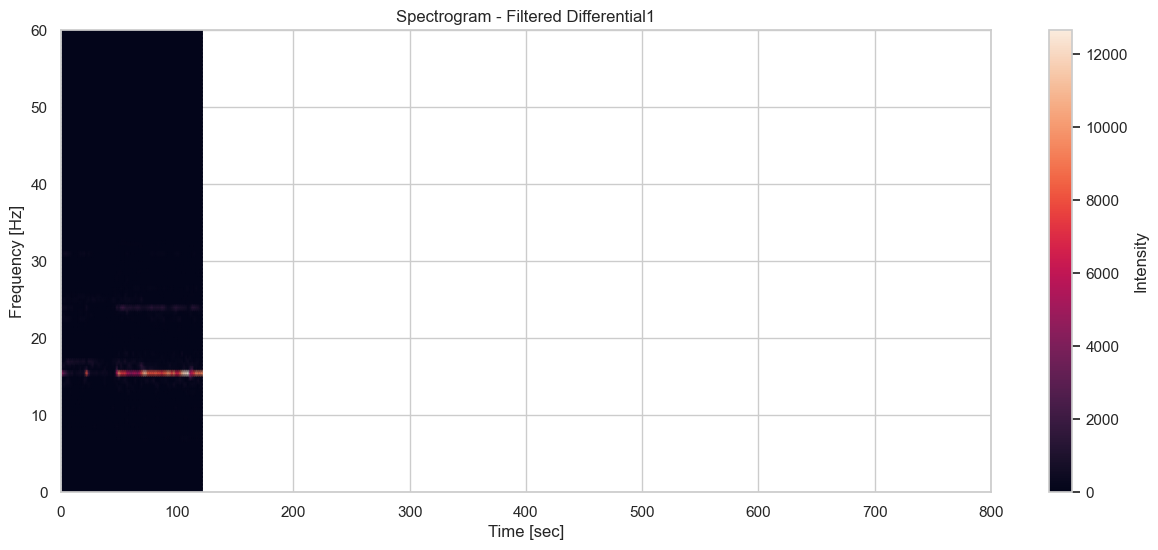

In [39]:
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from scipy.signal import spectrogram

# Load the CSV file
df = pd.read_csv('eeg_data_emotion1.csv')

print(df.info())
print(df.describe())

# Convert timestamp to datetime
df['Local_Timestamp'] = pd.to_datetime(df['Local_Timestamp'])

# Set as index
df.set_index('Local_Timestamp', inplace=True)


# Sampling rate and Nyquist frequency
fs = 128  # Hz
nyq = 0.5 * fs  

# Bandpass filter parameters
lowcut = 7  # Hz
highcut = 31  # Hz

# Notch filter parameters (e.g., 50 Hz or 60 Hz)
notch_freq = 60.0  # Hz (Change to 60.0 if applicable)
quality_factor = 30.0  # Quality factor for notch filter

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    # Apply zero-phase filter to avoid phase distortion
    y = filtfilt(b, a, data)
    return y

# Apply the bandpass filter to each differential channel
for diff in ['Differential1', 'Differential2', 'Differential3']:
    df[f'filtered_{diff}'] = bandpass_filter(df[diff], lowcut, highcut, fs, order=5)

def notch_filter(data, freq, fs, quality=30):
    nyq = 0.5 * fs
    # Design notch filter
    b, a = iirnotch(freq / nyq, quality)
    # Apply zero-phase filter
    y = filtfilt(b, a, data)
    return y

# Check if notch frequency is below Nyquist frequency
if notch_freq < nyq:
    for diff in ['filtered_Differential1', 'filtered_Differential2', 'filtered_Differential3']:
        df[diff] = notch_filter(df[diff], notch_freq, fs, quality=quality_factor)
else:
    print(f"Notch frequency {notch_freq} Hz is above Nyquist frequency {nyq} Hz. Skipping notch filter.")

sns.set(style="whitegrid")

# Plot raw vs filtered for differential1
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Differential1'], label='Raw Differential1', alpha=0.5)
plt.plot(df.index, df['filtered_Differential1'], label='Filtered Differential1', linewidth=2)
plt.title('EEG Differential1: Raw vs Filtered')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Function to plot PSD
def plot_psd(data, fs, title):
    f, Pxx = welch(data, fs, nperseg=1024)
    plt.figure(figsize=(10, 5))
    plt.semilogy(f, Pxx)
    plt.title(f'Power Spectral Density - {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (V²/Hz)')
    plt.xlim(0, 60)  # Adjust based on your analysis needs
    plt.ylim(10**-2, 10**3)
    plt.show()

# Plot PSD for filtered_differential1
plot_psd(df['filtered_Differential1'], fs, 'Filtered Differential1')


# Function to plot spectrogram
def plot_spectrogram(data, fs, title):
    f, t, Sxx = spectrogram(data, fs)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.title(f'Spectrogram - {title}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0, 60)  # Adjust based on your analysis needs
    plt.xlim(0,800)
    plt.colorbar(label='Intensity')
    plt.show()

# Plot spectrogram for filtered_differential1
plot_spectrogram(df['filtered_Differential1'], fs, 'Filtered Differential1')



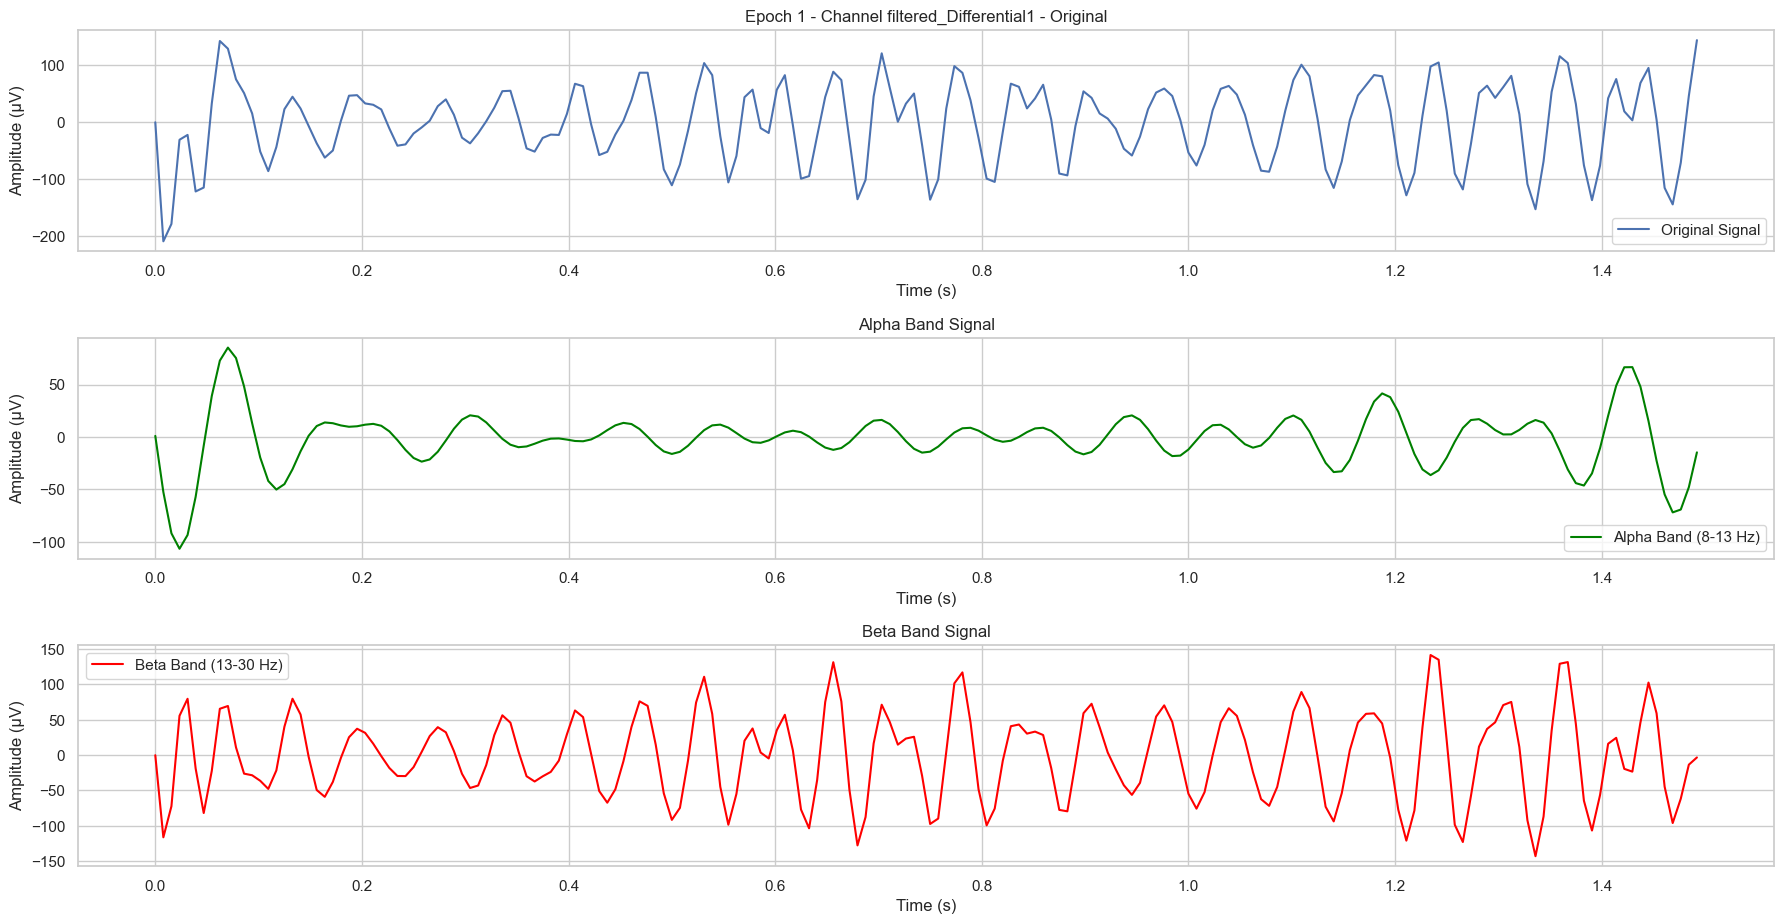

Combined PSD Features:
   Alpha_Ch1  Alpha_Ch2  Alpha_Ch3   Beta_Ch1   Beta_Ch2   Beta_Ch3
0   2.482904   2.600741   2.418718  50.503150  13.375416  33.363896
1   3.401446   1.030040   2.126170  42.431575  14.305563  29.775571
2   3.165493   2.600493   0.908944  52.508047  11.466392  32.318684
3   2.605068   1.334758   1.988979  32.956198  12.931960  15.156073
4   3.435830   1.150619   1.212380  27.399418  16.311774  12.133581


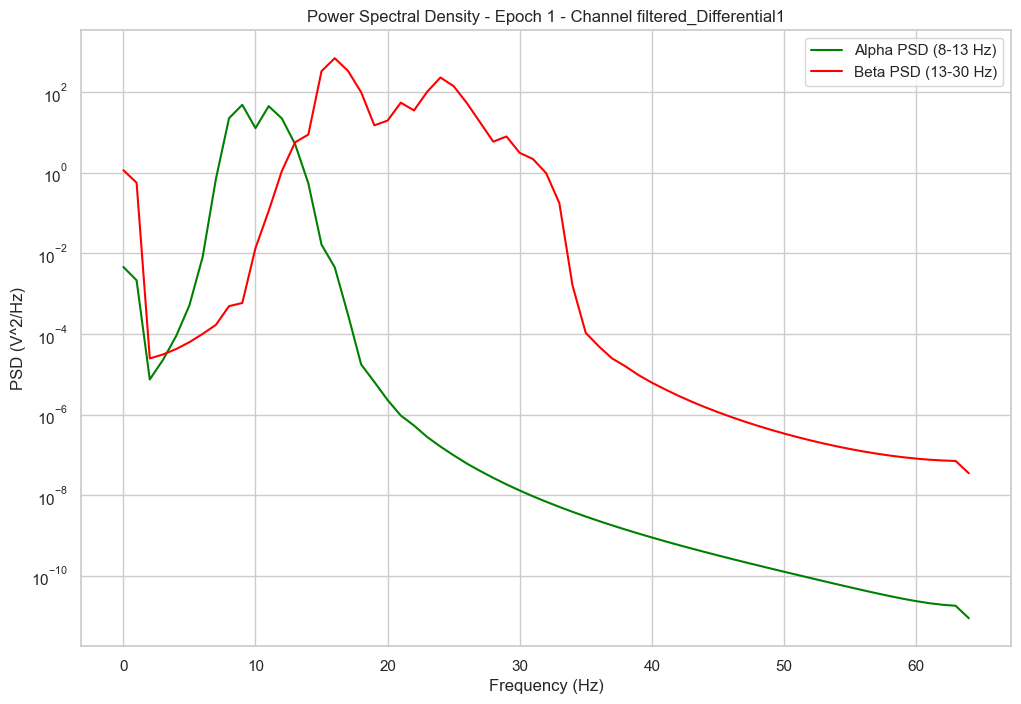

In [40]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt

# Step 1: Load and Verify Your Data
#filtered_csv_path = './eeg_data_filtered.csv'
#df_filtered = pd.read_csv(filtered_csv_path)
selected_columns = ['filtered_Differential1', 'filtered_Differential2', 'filtered_Differential3']
df_eeg = df[selected_columns]

# Step 2: Define Frequency Bands and Filter Parameters
fs = 128
alpha_band = (8, 13)
beta_band = (13, 30)
nyq = 0.5 * fs
alpha_low = alpha_band[0] / nyq
alpha_high = alpha_band[1] / nyq
beta_low = beta_band[0] / nyq
beta_high = beta_band[1] / nyq
order = 5

# Step 3: Design Band-Pass Filters Using SciPy
b_alpha, a_alpha = butter(order, [alpha_low, alpha_high], btype='band')
b_beta, a_beta = butter(order, [beta_low, beta_high], btype='band')

# Step 4: Apply Filters to Isolate Alpha, Beta Waves
data = df_eeg.values
epoch_length_sec = 1.5
epoch_length_samples = int(epoch_length_sec * fs)
n_samples = data.shape[0]
n_epochs = n_samples // epoch_length_samples
truncated_length = n_epochs * epoch_length_samples
data = data[:truncated_length]
epochs = data.reshape(n_epochs, epoch_length_samples, -1)

epochs_alpha = np.zeros_like(epochs)
epochs_beta = np.zeros_like(epochs)


for i in range(n_epochs):
    for ch in range(epochs.shape[2]):
        epochs_alpha[i, :, ch] = filtfilt(b_alpha, a_alpha, epochs[i, :, ch])
        epochs_beta[i, :, ch] = filtfilt(b_beta, a_beta, epochs[i, :, ch])

# Step 5: Visualize the Filtered Signals
epoch_idx = 0
channel_idx = 0
t = np.arange(0, epoch_length_sec, 1/fs)
original_signal = epochs[epoch_idx, :, channel_idx]
alpha_signal = epochs_alpha[epoch_idx, :, channel_idx]
beta_signal = epochs_beta[epoch_idx, :, channel_idx]


plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(t, original_signal, label='Original Signal')
plt.title(f'Epoch {epoch_idx+1} - Channel {selected_columns[channel_idx]} - Original')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, alpha_signal, color='green', label='Alpha Band (8-13 Hz)')
plt.title('Alpha Band Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, beta_signal, color='red', label='Beta Band (13-30 Hz)')
plt.title('Beta Band Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

# Step 6: Compute Power Spectral Density (PSD)
def compute_psd(data, fs):
    n_epochs = data.shape[0]
    psd_list = []
    for i in range(n_epochs):
        f, Pxx = welch(data[i, :], fs=fs, nperseg=fs)
        psd_list.append(Pxx)
    psd_array = np.array(psd_list)
    return f, psd_array

psd_alpha = {}
psd_beta = {}

for ch in range(epochs.shape[2]):
    # Alpha PSD
    f_alpha, Pxx_alpha = compute_psd(epochs_alpha[:, :, ch], fs)
    psd_alpha[f'Alpha_Ch{ch+1}'] = Pxx_alpha.mean(axis=1)
    
    # Beta PSD
    f_beta, Pxx_beta = compute_psd(epochs_beta[:, :, ch], fs)
    psd_beta[f'Beta_Ch{ch+1}'] = Pxx_beta.mean(axis=1)
    

# Step 7: Extract Features for Machine Learning
df_features = pd.DataFrame()

# Add Alpha features
for key in psd_alpha:
    df_features[key] = psd_alpha[key]

# Add Beta features
for key in psd_beta:
    df_features[key] = psd_beta[key]


print("Combined PSD Features:")
print(df_features.head())

# Step 8: Save Features to CSV
# Optional: Add labels
# labels = np.array([...])  # Replace with your actual labels
# df_features['Label'] = labels

##features_csv_path = './eeg_alpha_beta_psd_features.csv'
#df_features.to_csv(features_csv_path, index=False)
#print(f'Alpha and Beta PSD features saved to {features_csv_path}')

# Optional: Visualization of PSD for a single epoch and channel
plt.figure(figsize=(12, 8))
plt.semilogy(f_alpha, Pxx_alpha[epoch_idx], label='Alpha PSD (8-13 Hz)', color='green')
plt.semilogy(f_beta, Pxx_beta[epoch_idx], label='Beta PSD (13-30 Hz)', color='red')
plt.title(f'Power Spectral Density - Epoch {epoch_idx+1} - Channel {selected_columns[channel_idx]}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend()
plt.grid(True)
plt.show()


Positive Emotion

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18081 entries, 0 to 18080
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Differential1    18081 non-null  int64 
 1   Differential2    18081 non-null  int64 
 2   Differential3    18081 non-null  int64 
 3   Emotion          18081 non-null  object
 4   Local_Timestamp  18081 non-null  object
dtypes: int64(3), object(2)
memory usage: 706.4+ KB
None
       Differential1  Differential2  Differential3
count   18081.000000   18081.000000   18081.000000
mean     2451.169460    1993.119407    2163.036502
std       197.902258     154.528599     183.335159
min      1879.000000    1465.000000    1731.000000
25%      2300.000000    1890.000000    2047.000000
50%      2443.000000    2009.000000    2130.000000
75%      2611.000000    2086.000000    2282.000000
max      2955.000000    2570.000000    2749.000000


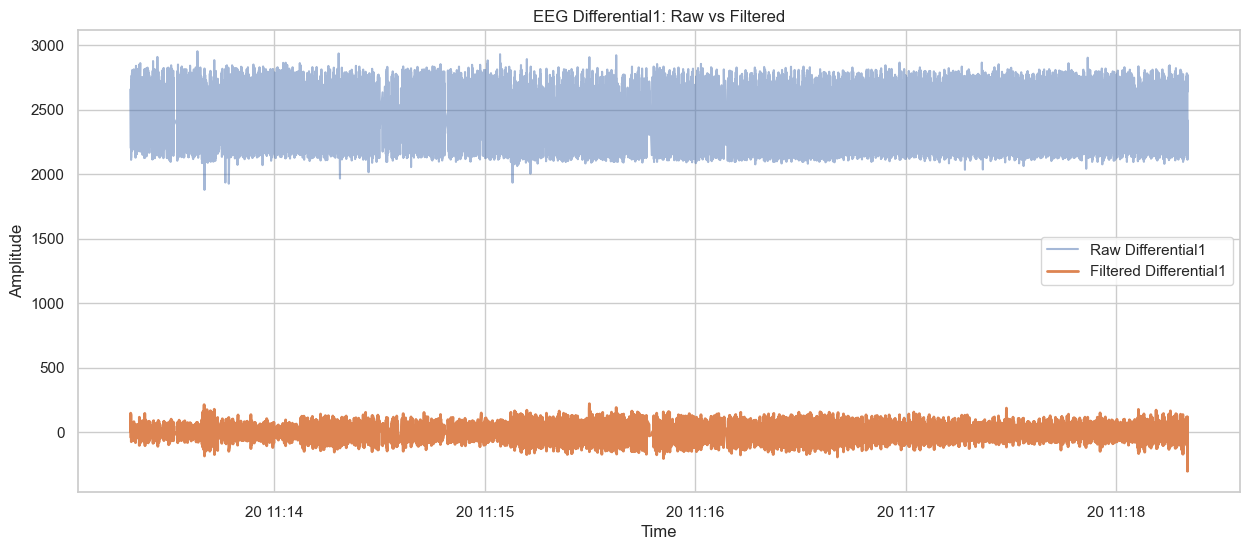

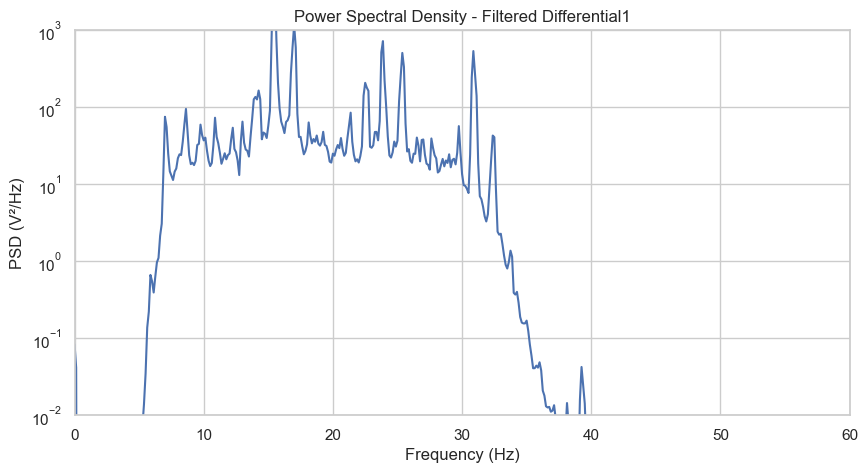

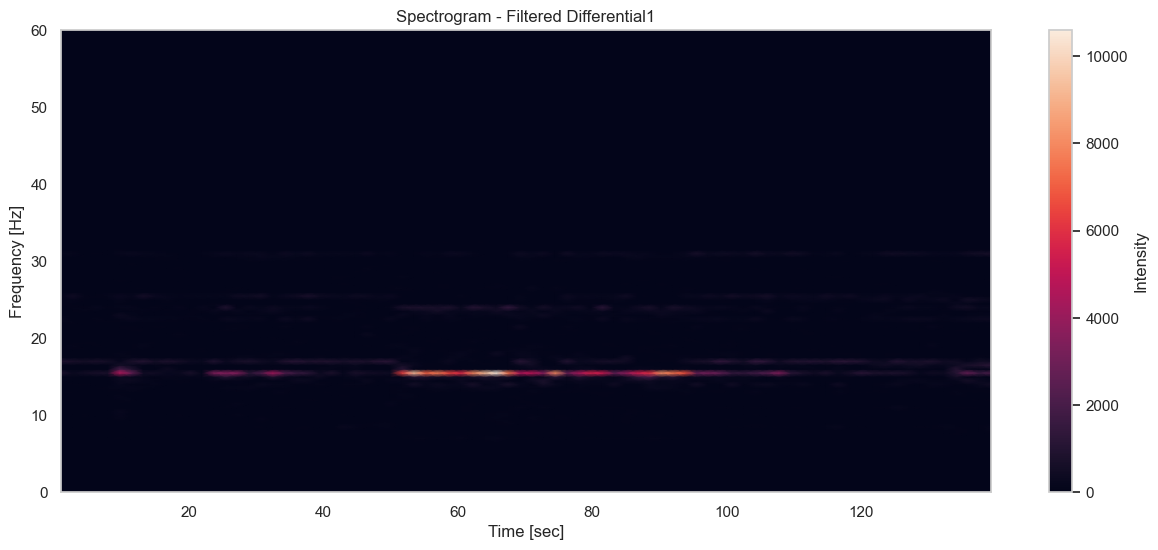

In [35]:
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from scipy.signal import spectrogram

# Load the CSV file
df = pd.read_csv('eeg_data_emotion2.csv')

print(df.info())
print(df.describe())

# Convert timestamp to datetime
df['Local_Timestamp'] = pd.to_datetime(df['Local_Timestamp'])

# Set as index
df.set_index('Local_Timestamp', inplace=True)

# Sampling rate and Nyquist frequency
fs = 128  # Hz
nyq = 0.5 * fs  

# Bandpass filter parameters
lowcut = 7  # Hz
highcut = 31  # Hz

# Notch filter parameters (e.g., 50 Hz or 60 Hz)
notch_freq = 60.0  # Hz (Change to 60.0 if applicable)
quality_factor = 30.0  # Quality factor for notch filter

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    # Apply zero-phase filter to avoid phase distortion
    y = filtfilt(b, a, data)
    return y

# Apply the bandpass filter to each differential channel
for diff in ['Differential1', 'Differential2', 'Differential3']:
    df[f'filtered_{diff}'] = bandpass_filter(df[diff], lowcut, highcut, fs, order=5)

def notch_filter(data, freq, fs, quality=30):
    nyq = 0.5 * fs
    # Design notch filter
    b, a = iirnotch(freq / nyq, quality)
    # Apply zero-phase filter
    y = filtfilt(b, a, data)
    return y

# Check if notch frequency is below Nyquist frequency
if notch_freq < nyq:
    for diff in ['filtered_Differential1', 'filtered_Differential2', 'filtered_Differential3']:
        df[diff] = notch_filter(df[diff], notch_freq, fs, quality=quality_factor)
else:
    print(f"Notch frequency {notch_freq} Hz is above Nyquist frequency {nyq} Hz. Skipping notch filter.")

sns.set(style="whitegrid")

# Plot raw vs filtered for differential1
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Differential1'], label='Raw Differential1', alpha=0.5)
plt.plot(df.index, df['filtered_Differential1'], label='Filtered Differential1', linewidth=2)
plt.title('EEG Differential1: Raw vs Filtered')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Function to plot PSD
def plot_psd(data, fs, title):
    f, Pxx = welch(data, fs, nperseg=1024)
    plt.figure(figsize=(10, 5))
    plt.semilogy(f, Pxx)
    plt.title(f'Power Spectral Density - {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (V²/Hz)')
    plt.xlim(0, 60)  # Adjust based on your analysis needs
    plt.ylim(10**-2, 10**3)
    plt.show()

# Plot PSD for filtered_differential1
plot_psd(df['filtered_Differential1'], fs, 'Filtered Differential1')


# Function to plot spectrogram
def plot_spectrogram(data, fs, title):
    f, t, Sxx = spectrogram(data, fs)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.title(f'Spectrogram - {title}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0, 60)  # Adjust based on your analysis needs
    plt.colorbar(label='Intensity')
    plt.show()

# Plot spectrogram for filtered_differential1
plot_spectrogram(df['filtered_Differential1'], fs, 'Filtered Differential1')



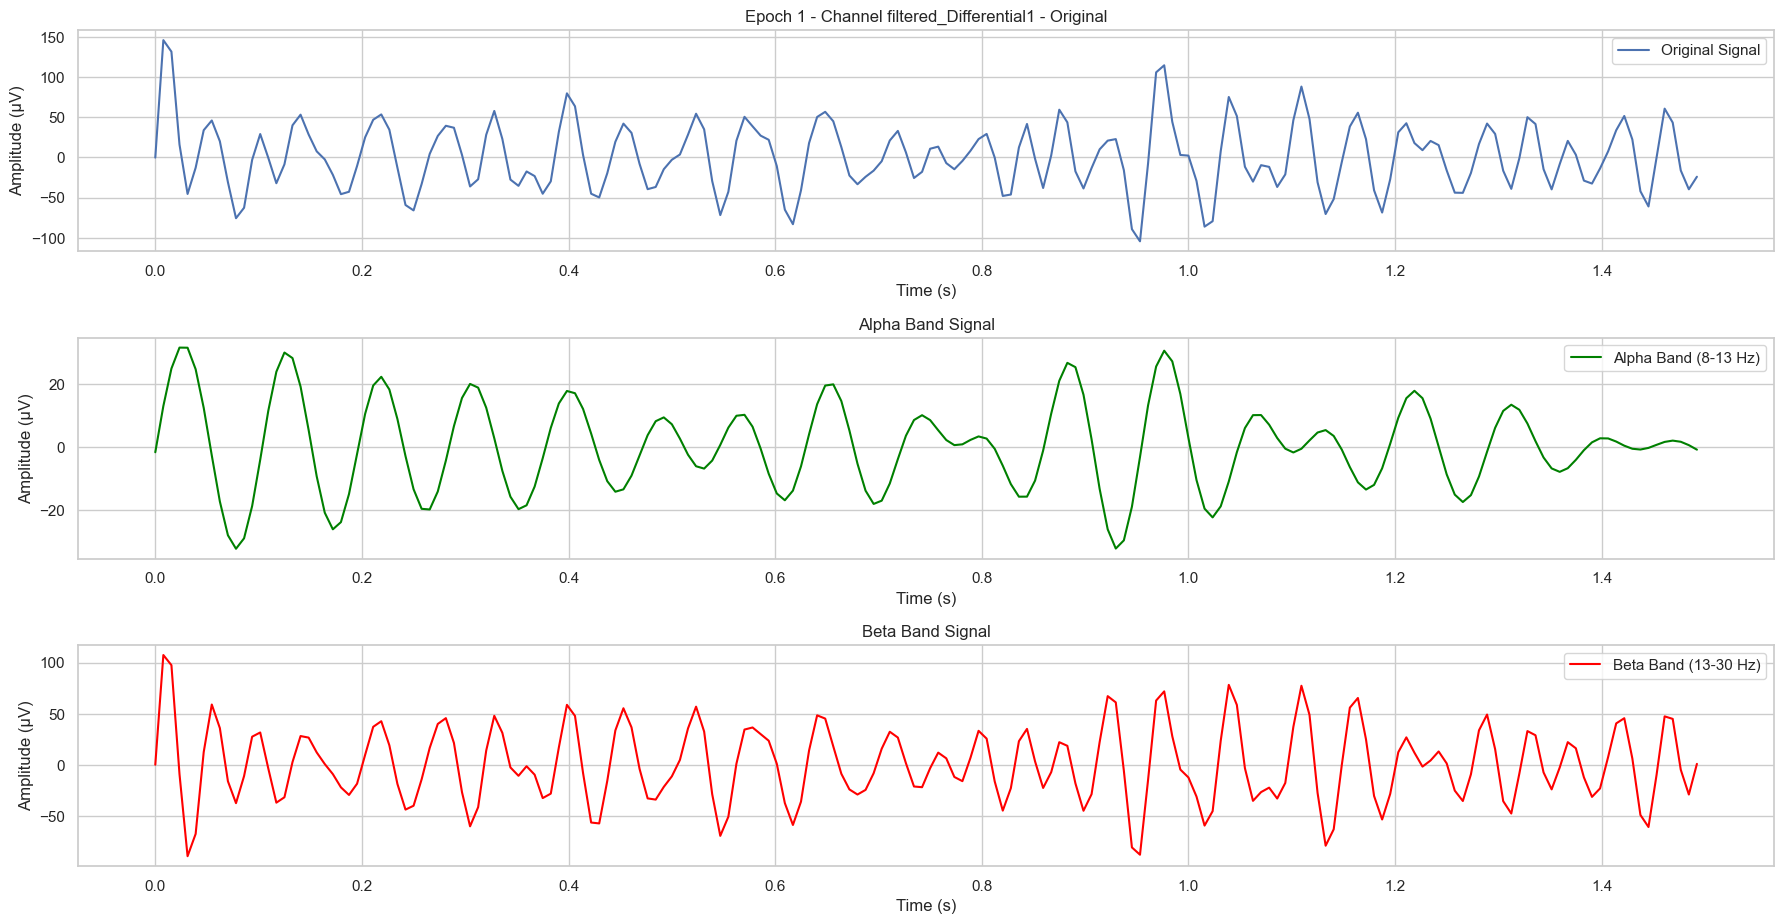

Combined PSD Features:
   Alpha_Ch1  Alpha_Ch2  Alpha_Ch3   Beta_Ch1   Beta_Ch2  Beta_Ch3
0   2.712465   2.044396   1.874746  22.441525  16.953813  8.056417
1   1.682667   1.308159   0.391894  25.680851  18.304500  8.530716
2   1.428479   1.013832   0.589306  19.001085  16.068442  5.238988
3   2.198335   0.856368   0.620413  20.743004  20.747503  6.315099
4   0.853734   1.138101   1.759740  14.755581  20.921798  5.986190
Alpha and Beta PSD features saved to ./eeg_alpha_beta_psd_features.csv


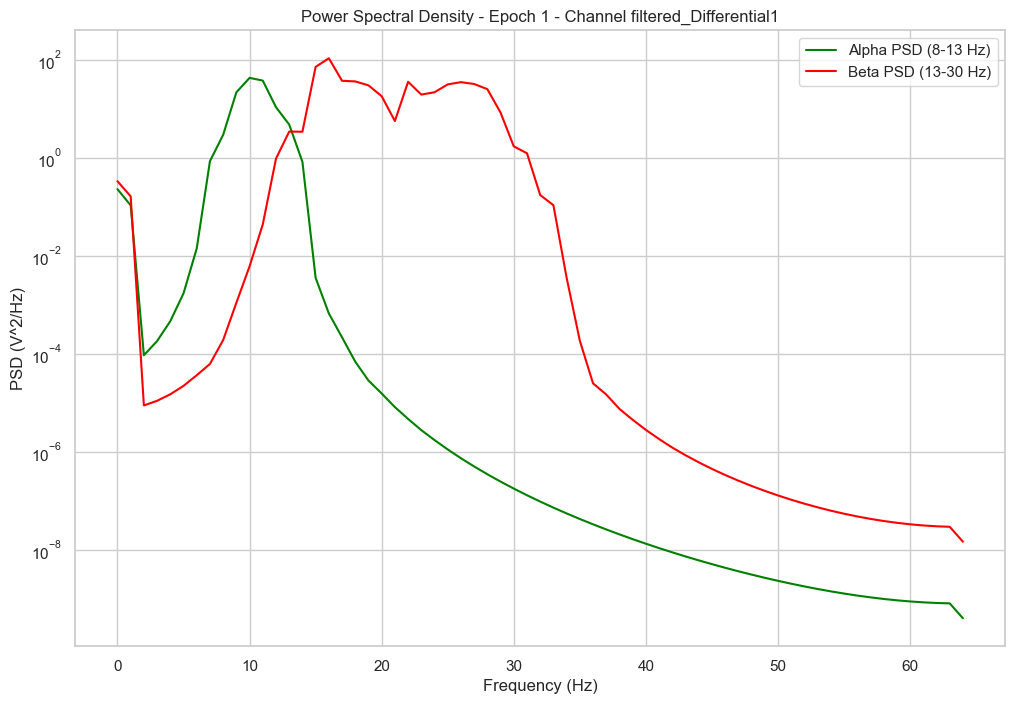

In [37]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt

# Step 1: Load and Verify Your Data
#filtered_csv_path = './eeg_data_filtered.csv'
#df_filtered = pd.read_csv(filtered_csv_path)
selected_columns = ['filtered_Differential1', 'filtered_Differential2', 'filtered_Differential3']
df_eeg = df[selected_columns]

# Step 2: Define Frequency Bands and Filter Parameters
fs = 128
alpha_band = (8, 13)
beta_band = (13, 30)
nyq = 0.5 * fs
alpha_low = alpha_band[0] / nyq
alpha_high = alpha_band[1] / nyq
beta_low = beta_band[0] / nyq
beta_high = beta_band[1] / nyq
order = 5

# Step 3: Design Band-Pass Filters Using SciPy
b_alpha, a_alpha = butter(order, [alpha_low, alpha_high], btype='band')
b_beta, a_beta = butter(order, [beta_low, beta_high], btype='band')

# Step 4: Apply Filters to Isolate Alpha, Beta Waves
data = df_eeg.values
epoch_length_sec = 1.5
epoch_length_samples = int(epoch_length_sec * fs)
n_samples = data.shape[0]
n_epochs = n_samples // epoch_length_samples
truncated_length = n_epochs * epoch_length_samples
data = data[:truncated_length]
epochs = data.reshape(n_epochs, epoch_length_samples, -1)

epochs_alpha = np.zeros_like(epochs)
epochs_beta = np.zeros_like(epochs)


for i in range(n_epochs):
    for ch in range(epochs.shape[2]):
        epochs_alpha[i, :, ch] = filtfilt(b_alpha, a_alpha, epochs[i, :, ch])
        epochs_beta[i, :, ch] = filtfilt(b_beta, a_beta, epochs[i, :, ch])

# Step 5: Visualize the Filtered Signals
epoch_idx = 0
channel_idx = 0
t = np.arange(0, epoch_length_sec, 1/fs)
original_signal = epochs[epoch_idx, :, channel_idx]
alpha_signal = epochs_alpha[epoch_idx, :, channel_idx]
beta_signal = epochs_beta[epoch_idx, :, channel_idx]


plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(t, original_signal, label='Original Signal')
plt.title(f'Epoch {epoch_idx+1} - Channel {selected_columns[channel_idx]} - Original')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, alpha_signal, color='green', label='Alpha Band (8-13 Hz)')
plt.title('Alpha Band Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, beta_signal, color='red', label='Beta Band (13-30 Hz)')
plt.title('Beta Band Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

# Step 6: Compute Power Spectral Density (PSD)
def compute_psd(data, fs):
    n_epochs = data.shape[0]
    psd_list = []
    for i in range(n_epochs):
        f, Pxx = welch(data[i, :], fs=fs, nperseg=fs)
        psd_list.append(Pxx)
    psd_array = np.array(psd_list)
    return f, psd_array

psd_alpha = {}
psd_beta = {}

for ch in range(epochs.shape[2]):
    # Alpha PSD
    f_alpha, Pxx_alpha = compute_psd(epochs_alpha[:, :, ch], fs)
    psd_alpha[f'Alpha_Ch{ch+1}'] = Pxx_alpha.mean(axis=1)
    
    # Beta PSD
    f_beta, Pxx_beta = compute_psd(epochs_beta[:, :, ch], fs)
    psd_beta[f'Beta_Ch{ch+1}'] = Pxx_beta.mean(axis=1)
    

# Step 7: Extract Features for Machine Learning
df_features = pd.DataFrame()

# Add Alpha features
for key in psd_alpha:
    df_features[key] = psd_alpha[key]

# Add Beta features
for key in psd_beta:
    df_features[key] = psd_beta[key]


print("Combined PSD Features:")
print(df_features.head())

# Step 8: Save Features to CSV
# Optional: Add labels
# labels = np.array([...])  # Replace with your actual labels
# df_features['Label'] = labels

features_csv_path = './eeg_alpha_beta_psd_features.csv'
df_features.to_csv(features_csv_path, index=False)
print(f'Alpha and Beta PSD features saved to {features_csv_path}')

# Optional: Visualization of PSD for a single epoch and channel
plt.figure(figsize=(12, 8))
plt.semilogy(f_alpha, Pxx_alpha[epoch_idx], label='Alpha PSD (8-13 Hz)', color='green')
plt.semilogy(f_beta, Pxx_beta[epoch_idx], label='Beta PSD (13-30 Hz)', color='red')
plt.title(f'Power Spectral Density - Epoch {epoch_idx+1} - Channel {selected_columns[channel_idx]}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend()
plt.grid(True)
plt.show()
